In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import rescale
from scipy.ndimage import rotate

import chromatix.functional as cf
from jax import Array, vmap, pmap, jit, value_and_grad
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates

%config InlineBackend.figure_format='retina'

# Making dataset

We first make a dataset. Let's use the standard shepp-logan phantom, and stack it a few times.

In [2]:
# Getting phantom
image = shepp_logan_phantom().astype(np.float16)
image = rescale(image, scale=0.64, mode='reflect', channel_axis=None)
print(image.shape)

(256, 256)


Let's use 48 rotations:

In [3]:
# Rotating image
angles = np.linspace(0, 360, 48, endpoint=False)
dataset = np.stack([rotate(image, angle, reshape=False, order=1) for angle in angles])

# Adding in fake y axis - just repeated
dataset = np.repeat(np.expand_dims(dataset, 1), 256, axis=1)
dataset = np.moveaxis(dataset, -1, 1)
print(f"Dataset shape [angle, z, y, x]: {dataset.shape}")

Dataset shape [angle, z, y, x]: (48, 256, 256, 256)


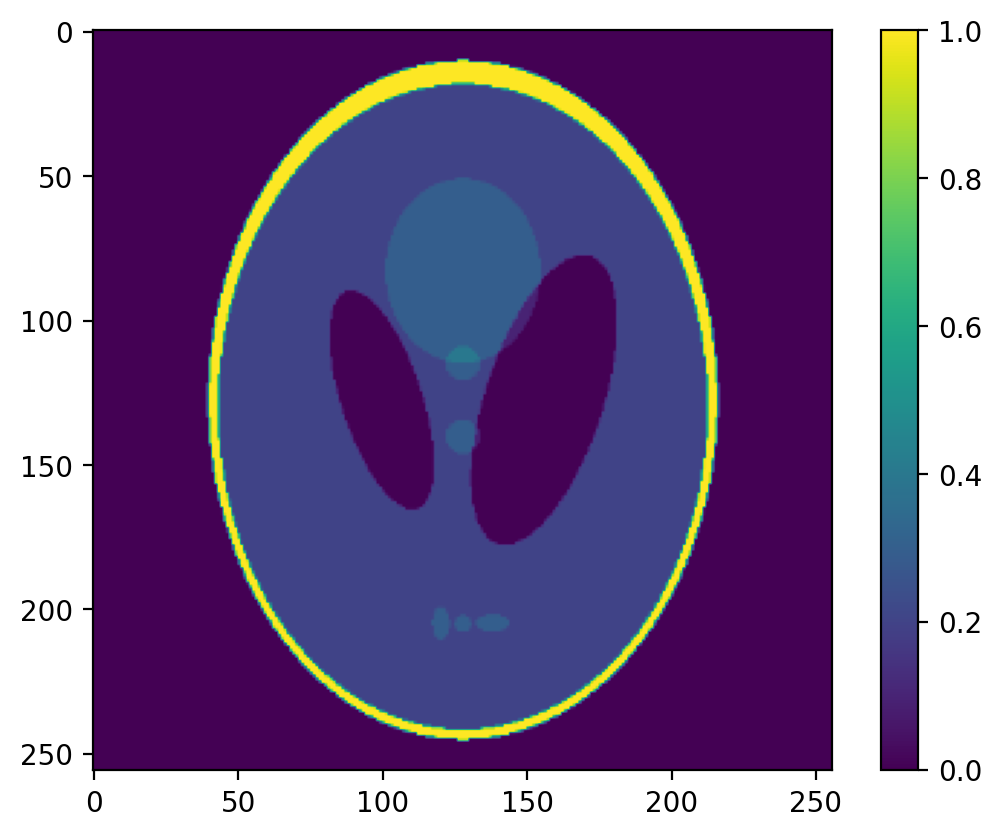

In [4]:
plt.imshow(dataset[12, :, 6, :])
plt.colorbar()
plt.show()

# Forward model

In [9]:
# Scaled fresnel model

def forward(phantom: Array) -> Array:
    # Some settings - taken from ESRF
    shape = phantom.shape[1:]
    dx = 30e-3 # spacing of 30nm
    spectrum = 7.25146e-5
    spectral_density = 1.0
    n = 1 - 1e-9
    N_pad = 256
    z_total = 1.208 * 1e6
    z_obj = 0.0059655 * 1e6
    
    # Settings for fresnel scaled propagation
    M = z_total / z_obj  # magnification
    z_eff = (z_total - z_obj) / M
    
    # We use fresnel scaled propagation
    field = cf.plane_wave(shape, dx, spectrum, spectral_density, power=1e6)
    field = cf.multislice_thick_sample(field, 10 * phantom, jnp.zeros_like(phantom), n=n, thickness_per_slice=dx, N_pad=N_pad)
    field = cf.transfer_propagate(field, z=z_eff, n=n, N_pad=N_pad, mode="same")
    field = field.replace(u=field.u / M, _dx = field.dx * M)
    
    return field.intensity.squeeze()

In [10]:
# To do everything in parallel, we pmap over vmap - 6 angles / GPU, 8 GPUS
forward_fn = pmap(vmap(forward))

observed_intensities = forward_fn(dataset.reshape(8, 6, 256, 256, 256)).reshape(-1, 256, 256)

In [11]:
observed_intensities.shape

(48, 256, 256)

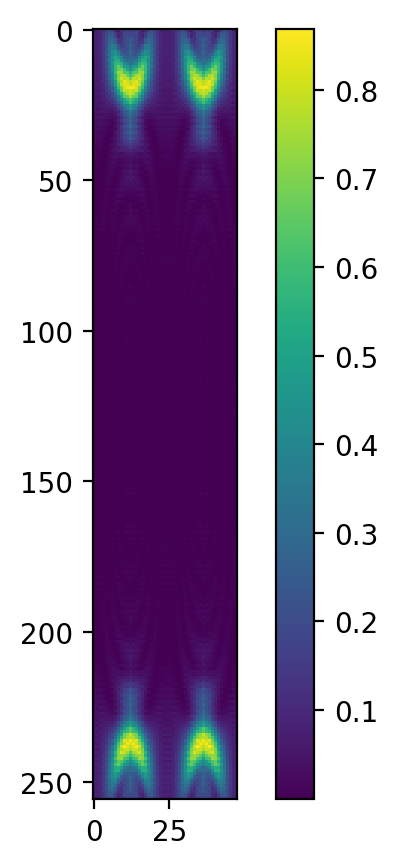

In [12]:
plt.figure(figsize=(5, 5))
plt.imshow(observed_intensities[:, 100, :].T)
plt.colorbar()

We now have our data!

# Training

In [13]:
import jax
import optax
from functools import partial

In [14]:
@jax.jit
def loss_fn(learned_phantom, data, angle):
    intensity = forward(diff_rotate(learned_phantom, -angle / 180 * jnp.pi))
    return jnp.mean((intensity - data)**2) / jnp.mean(data**2)

In [23]:
params = jnp.zeros((256, 256, 256))
devices = jax.local_devices()
params = jax.device_put_replicated(params, devices)

In [19]:
losses = [loss_fn(dataset[0], observed_intensities[idx], angles[idx]) for idx in range(dataset.shape[0])]
print(np.max(np.abs(losses)))

1.4980103e-09


In [20]:
@partial(pmap, axis_name="devices")
def get_grads(learned_phantom, data, angle):
    def _loss_fn(params):
        return jnp.mean(vmap(loss_fn, in_axes=(None, 0, 0))(params, data, angle))
    
    loss, grads = value_and_grad(_loss_fn)(learned_phantom)
    loss = jax.lax.pmean(loss, 'devices')
    grads = jax.lax.pmean(grads, 'devices')
    return loss, grads

In [40]:
optimizer = optax.adam(1e-3)
opt_state = pmap(optimizer.init)(params)
n_gpus = len(devices)

In [41]:
for iteration in range(2000):
    idx = np.random.randint(0, 48, size=n_gpus)
    losses, grads = get_grads(params, observed_intensities[idx][:, None], angles[idx][:, None])
    #grads = (grads - grads.mean()) / grads.std()
    grads = (2 * (grads - grads.min()) / (grads.max() - grads.min()) - 1) # rescaling grads
    updates, opt_state = pmap(optimizer.update)(grads, opt_state, params)
    params = pmap(optax.apply_updates)(params, updates)
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, loss {losses[0].squeeze():.3f}")

Iteration 0, loss 62.968
Iteration 100, loss nan


Exception ignored in: <function _xla_gc_callback at 0x1532eaae5480>
Traceback (most recent call last):
  File "/groups/turaga/home/bothg/venvs/chromatix/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
plt.subplot(121)
plt.title("Inferred")
plt.imshow(params[0, :, 128, :])

plt.subplot(122)
plt.title("target")
plt.imshow(dataset[0, :, 128, :])

In [ ]:
plt.subplot(121)
plt.title("Inferred")
plt.imshow(params[0, :, 128, :])

plt.subplot(122)
plt.title("target")
plt.imshow(dataset[0, :, 128, :])

In [ ]:
plt.plot(params[0, :, 128, 128])
plt.plot(dataset[0, :, 128, 128])

In [ ]:
plt.subplot(121)
plt.title("Inferred")
plt.imshow(params[0, :, :, 128])

plt.subplot(122)
plt.title("target")
plt.imshow(dataset[0, :, :, 128])

In [ ]:
plt.subplot(121)
plt.title("Inferred")
plt.imshow(params[0, 128, :, :])

plt.subplot(122)
plt.title("target")
plt.imshow(dataset[0, 128, :, :])

# Rotations

In [18]:
def diff_rotate(volume, angle):
    Nx, Ny, Nz = volume.shape
    # Making grid
    grid = jnp.mgrid[-Nx // 2 : Nx // 2, -Ny // 2 : Ny // 2, -Nz // 2 : Nz // 2] + 1/2
    grid = jnp.transpose(grid, (1, 2, 3, 0))
    # adding homogeneous coordinates
    grid = jnp.concatenate([grid, jnp.ones((*grid.shape[:3], 1))], axis=-1)
    
    # making affine matrix
    M = jnp.eye(4)
    M = M @ Ryz(angle)
    
    # Deforming grid and resampling
    deformed_grid = (grid @ M.transpose())[..., :3]
    return resample(volume, deformed_grid)

def resample(vol: Array, grid: Array) -> jnp.ndarray:
    # assume original coordinates were centered, i.e. -N/2 -> N/2
    offset = jnp.array(vol.shape)[:, None] // 2 - 1/2
    resampled = map_coordinates(vol, grid.reshape(-1, 3).T + offset, order=1, mode='constant', cval=0.0)
    return resampled.reshape(grid.shape[:3])

def Ryz(theta: float) -> jnp.ndarray:
    """Roll rotations."""
    R = jnp.zeros((4, 4))

    sin_t = jnp.sin(theta)
    cos_t = jnp.cos(theta)

    R = R.at[1, 1].set(1.0)
    R = R.at[3, 3].set(1.0)  # homogeneous
    R = R.at[0, 0].set(cos_t)
    R = R.at[2, 2].set(cos_t)
    R = R.at[0, 2].set(sin_t)
    R = R.at[2, 0].set(-sin_t)

    return R